In [ ]:
# choose destination, arrival and date: %Done%
# get the data from GDS: %Done%
# find all the NZ flights with zero stops: %Done%
# complete the drop down for time: %Done%
# complete the drop down class: %Done%

# user chooses a Time and class

# go through all flights that are not NZ and find similar ones: Done

In [1]:
import json
import pandas as pd

In [2]:
from amadeus import Client, ResponseError

amadeus = Client(
    client_id='Iypd66o7JF7XLjpO8Qkq4ryb0Vp0bSKb',
    client_secret='d49teX5dV3xPA2SS'
)

In [3]:
from datetime import datetime, timedelta
from amadeus import Client, ResponseError
import time

def get_flights_info(departure_city, arrival_city, date, day_range=0):
    flights_info = []  # List to store flights data from all dates
    start_date = datetime.strptime(date, '%Y-%m-%d') - timedelta(days=day_range)
    end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=day_range)
    current_date = start_date
    while current_date <= end_date:
        try:
            response = amadeus.shopping.flight_offers_search.get(
                originLocationCode=departure_city,
                destinationLocationCode=arrival_city,
                departureDate=current_date.strftime('%Y-%m-%d'),
                adults=1)
            flights_info.extend(response.data)  # Add the results to the list
        except ResponseError as error:
            print(error)
        current_date += timedelta(days=1)  # Move to the next date

    return flights_info

In [41]:
import pandas as pd

def filter_flights_by_departure_date(flights_df, departure_date):
    """
    Filter and return flights that depart on the specified date.
    
    Parameters:
    - flights_df: DataFrame containing flight information.
    - departure_date: String specifying the departure date in 'YYYY-MM-DD' format.
    
    Returns:
    - DataFrame containing flights departing on the specified date.
    """
    # Ensure DepartureDate is in datetime.date format for comparison
    # This step assumes that the DepartureDate column is already in a date format.
    # If DepartureDate was originally datetime, ensure it's converted to date during DataFrame preparation.
    if isinstance(departure_date, str):
        departure_date = pd.to_datetime(departure_date).date()
    filtered_flights = flights_df[flights_df['DepartureTime'] == departure_date]
    
    return filtered_flights

def filter_flights_by_time_and_class(flights_df, departure_time=None, cabin=None):
    """
    Filter and return flights that match specified criteria including departure date, time, and cabin class.
    
    Parameters:
    - flights_df: DataFrame containing flight information.
    - departure_date: String specifying the departure date in 'YYYY-MM-DD' format.
    - departure_time: String or datetime.time specifying the departure time (optional).
    - cabin: String specifying the cabin class (optional).
    
    Returns:
    - DataFrame containing flights that match the specified criteria.
    """
    
    # Filter by departure time if specified
    if departure_time is not None:
        # If departure_time is a string, convert it to a time object for comparison
        if isinstance(departure_time, str):
            departure_time = pd.to_datetime(departure_time).time()
        filtered_flights = flights_df[flights_df['DepartureTime'] == departure_time]
    
    # Filter by cabin if specified
    if cabin is not None:
        filtered_flights = filtered_flights[filtered_flights['Cabin'] == cabin]
    
    return filtered_flights

In [32]:
# this goes to util

def parse_duration(duration_str):
    """
    Parses a duration string in ISO 8601 format and returns the total duration in minutes.
    """
    hours = 0
    minutes = 0
    if 'H' in duration_str:
        hours = int(duration_str.split('H')[0].replace('PT', ''))
        if 'M' in duration_str:
            minutes = int(duration_str.split('H')[1].replace('M', ''))
    elif 'M' in duration_str:
        minutes = int(duration_str.replace('PT', '').replace('M', ''))
    return hours * 60 + minutes

# Function to categorize departure time
def time_of_day(hour):
    if 0 <= hour < 6:
        return 'Early Morning'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
    
# Function to categorize flights as Short-haul, Medium-haul, or Long-haul
def categorize_flight_haul(duration):
    if duration <= 180: # Short-haul flights are less than or equal to 3 hours
        return 'Short-haul'
    elif duration <= 360: # Medium-haul flights are between 3 to 6 hours
        return 'Medium-haul'
    else: # Long-haul flights are more than 6 hours
        return 'Long-haul'
    
def is_overnight_flight(row):
    """
    Determine if a flight is an overnight flight.
    A flight is considered overnight if it arrives on the next day after it departs.
    """
    departure_hours = row['DepartureDateTime'].hour
    arrival_hours = row['ArrivalDateTime'].hour
    return ((arrival_hours < departure_hours) & (row['TotalDuration'] > 60)) | ((arrival_hours + 24 - departure_hours) * 60 < row['TotalDuration'])

def parse_flight_details(flight_data):
    # Initialize data holders
    segments_data = []
    prices_data = []
    flights_data = []
    fares_data = []
    
    itinerary_id_counter = 1
    flight_id_counter = 1
    
    for offer in flight_data:
        for itinerary in offer["itineraries"]:
            # Parse itinerary information
            segments = itinerary["segments"]
            itinerary_duration = parse_duration(itinerary["duration"])
            # Parse segment information for each segment in the itinerary
            for segment in segments:
                aircraft_code = segment["aircraft"]["code"] if "aircraft" in segment else "Unknown"
                segment_duration_minutes = parse_duration(segment["duration"])
                segments_data.append({
                    "ItineraryID": itinerary_id_counter,
                    "FlightID": flight_id_counter,
                    "Duration": segment_duration_minutes,
                    "Departure": segment["departure"]["iataCode"],
                    "Arrival": segment["arrival"]["iataCode"],
                    "CarrierCode": segment["carrierCode"],
                    "DepartureDateTime": segment["departure"]["at"],
                    "ArrivalDateTime": segment["arrival"]["at"],
                    "NumberOfStops": segment["numberOfStops"],
                    "AircraftCode": aircraft_code
                })
                
                # Add fare details for each segment if available
                for traveler_pricing in offer["travelerPricings"]:
                    for fare_detail in traveler_pricing["fareDetailsBySegment"]:
                        if fare_detail["segmentId"] == segment["id"]:
                            fares_data.append({
                                "ItineraryID": itinerary_id_counter,
                                "FlightID": flight_id_counter,
                                "Cabin": fare_detail["cabin"],
                                "Class": fare_detail["class"],
                                "FareBasis": fare_detail["fareBasis"],
                                "IncludedCheckedBagsQuantity": fare_detail.get("includedCheckedBags", {}).get("quantity", 0)
                            })
                
                flight_id_counter += 1
            
            # Parse flight information based on the whole itinerary
            flights_data.append({
                "ItineraryID": itinerary_id_counter,
                "Departure": segments[0]["departure"]["iataCode"],
                "Arrival": segments[-1]["arrival"]["iataCode"],
                "DepartureDateTime": segments[0]["departure"]["at"],
                "ArrivalDateTime": segments[-1]["arrival"]["at"],
                "TotalDuration": itinerary_duration,
                "NumberOfStops": len(segments) - 1,
            })
            
            # Prices for each itinerary
            prices_data.append({
                "ItineraryID": itinerary_id_counter,
                "Currency": offer["price"]["currency"],
                "Total": offer["price"]["total"],
                "Base": offer["price"]["base"],
            })

            itinerary_id_counter += 1
            
    segments_data = pd.DataFrame(segments_data)
    segments_data['DepartureDateTime'] = pd.to_datetime(segments_data['DepartureDateTime'])
    segments_data['ArrivalDateTime'] = pd.to_datetime(segments_data['ArrivalDateTime'])
    segments_data['DepartureDate'] = segments_data['DepartureDateTime'].dt.date
    segments_data['ArrivalDate'] = segments_data['ArrivalDateTime'].dt.date
    segments_data['DepartureTime'] = segments_data['DepartureDateTime'].dt.time
    segments_data['ArrivalTime'] = segments_data['ArrivalDateTime'].dt.time
    segments_data.rename(columns={'NumberOfStops': 'SegmentNumberOfStops'}, inplace=True)
    flights_data = pd.DataFrame(flights_data)
    flights_data['DepartureDateTime'] = pd.to_datetime(flights_data['DepartureDateTime'])
    flights_data['ArrivalDateTime'] = pd.to_datetime(flights_data['ArrivalDateTime'])
    flights_data['DepartureDate'] = flights_data['DepartureDateTime'].dt.date
    flights_data['ArrivalDate'] = flights_data['ArrivalDateTime'].dt.date
    flights_data['DepartureTime'] = flights_data['DepartureDateTime'].dt.time
    flights_data['ArrivalTime'] = flights_data['ArrivalDateTime'].dt.time
    flights_data['Departure_TimeOfDay'] = flights_data['DepartureDateTime'].dt.hour.apply(time_of_day)
    flights_data['IsWeekend_Departure'] = flights_data['DepartureDateTime'].dt.dayofweek >= 5
    flights_data['FlightHaul'] = flights_data['TotalDuration'].apply(categorize_flight_haul)
    flights_data['IsNonStop'] = flights_data['NumberOfStops'] == 0
    flights_data['IsOverNightFlight'] = flights_data.apply(is_overnight_flight, axis=1)
    
    prices_data = pd.DataFrame(prices_data)
    prices_data['Total'] = prices_data['Total'].astype(float)
    prices_data['Base'] = prices_data['Base'].astype(float)
    prices_data['FareCategory'] = pd.qcut(prices_data['Total'], q=3, labels=['Low', 'Medium', 'High'])
    prices_data['TotalZScore'] = (prices_data['Total'] - prices_data['Total'].mean()) / prices_data['Total'].std()

    fares_data = pd.DataFrame(fares_data)
    fares_data['FlightsPerItinerary'] = fares_data.groupby('ItineraryID')['FlightID'].transform('count')
    
    return segments_data, prices_data, flights_data, fares_data

In [33]:
flights_info = get_flights_info('AKL', 'SYD', '2024-03-24', day_range=1)

In [34]:
segments, prices, flights, fares = parse_flight_details(flights_info)

In [35]:
NZ_carriers = segments[segments['CarrierCode'] == 'NZ']
merged_flights = pd.merge(NZ_carriers, flights, on='ItineraryID', suffixes=('', '_drop'))
merged_flights = pd.merge(merged_flights, fares, on=['ItineraryID', 'FlightID'], suffixes=('', '_drop'))
NZ_flights = merged_flights.loc[:, ~merged_flights.columns.str.endswith('_drop')]


NZ_nonStop_flights = NZ_flights.query("NumberOfStops == 0")

non_NZ_flights = flights[~flights['ItineraryID'].isin(NZ_flights['ItineraryID'])]
non_NZ_flights = pd.merge(non_NZ_flights, fares, on=['ItineraryID'], suffixes=('', '_drop'))
non_NZ_flights = non_NZ_flights.loc[:, ~non_NZ_flights.columns.str.endswith('_drop')]

In [42]:
filter_flights_by_departure_date(NZ_nonStop_flights, '2024-03-24')

,ItineraryID,FlightID,Duration,Departure,Arrival,CarrierCode,DepartureDateTime,ArrivalDateTime,SegmentNumberOfStops,AircraftCode,...,Departure_TimeOfDay,IsWeekend_Departure,FlightHaul,IsNonStop,IsOverNightFlight,Cabin,Class,FareBasis,IncludedCheckedBagsQuantity,FlightsPerItinerary
18,83,145,205,AKL,SYD,NZ,2024-03-24 09:00:00,2024-03-24 10:25:00,0,77W,...,Morning,True,Medium-haul,True,False,ECONOMY,W,WBAGNSS,1,1
19,84,146,205,AKL,SYD,NZ,2024-03-24 12:45:00,2024-03-24 14:10:00,0,32Q,...,Afternoon,True,Medium-haul,True,False,ECONOMY,W,WBAGNSS,1,1
20,85,147,220,AKL,SYD,NZ,2024-03-24 07:00:00,2024-03-24 08:40:00,0,32Q,...,Morning,True,Medium-haul,True,False,ECONOMY,W,WBAGNSS,1,1
21,86,148,220,AKL,SYD,NZ,2024-03-24 16:20:00,2024-03-24 18:00:00,0,32Q,...,Afternoon,True,Medium-haul,True,False,ECONOMY,W,WBAGNSS,1,1


In [8]:
def FlightHaul_similarity(flight_haul1, flight_haul2):
    """
    Calculate similarity between two times of day, returning a score between 0 and 1.
    Closer times of day have higher scores.
    """
    # Define an ordered list of times of day for reference
    flight_hauls = ['Short-haul', 'Medium-haul', 'Long-haul']
    
    # Calculate the difference in indices between the two times
    diff = abs(flight_hauls.index(flight_haul1) - flight_hauls.index(flight_haul2))
    
    # Assign scores based on the difference
    if diff == 0:
        return 1  # Exact match
    elif diff == 1:
        return 0.75  # Adjacent 
    elif diff == 2:
        return 0.5  # One step removed
    else:
        return 0.25  # Furthest apart
    
def time_of_day_similarity(time1, time2):
    """
    Calculate similarity between two times of day, returning a score between 0 and 1.
    Closer times of day have higher scores.
    """
    # Define an ordered list of times of day for reference
    times_of_day = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night']
    
    # Calculate the difference in indices between the two times
    diff = abs(times_of_day.index(time1) - times_of_day.index(time2))
    
    # Assign scores based on the difference
    if diff == 0:
        return 1  # Exact match
    elif diff == 1:
        return 0.75  # Adjacent times of day
    elif diff == 2:
        return 0.5  # One step removed
    else:
        return 0.25  # Furthest apart (Morning vs. Night or vice versa)

def calculate_similarity_score(flight_a, flight_b):
    """
    Calculate a similarity score between two flights based on specified criteria.
    
    Parameters:
    - flight_a: The first flight (a Series or similar structure).
    - flight_b: The second flight (a Series or similar structure).
    
    Returns:
    - A similarity score (the higher, the more similar).
    """
    score = 0
    # Points for NumberOfStops match
    if flight_a['NumberOfStops'] == flight_b['NumberOfStops']:
        score += 2
    if flight_a['Cabin'] == flight_b['Cabin']:
        score += 2
    score += time_of_day_similarity(flight_a['Departure_TimeOfDay'], flight_b['Departure_TimeOfDay'])
    # Points for FlightHaul match 
    score += FlightHaul_similarity(flight_a['FlightHaul'], flight_b['FlightHaul'])
    # Add more sophisticated handling for FlightHaul if needed

    # Points for IsOverNightFlight match
    if flight_a['IsOverNightFlight'] == flight_b['IsOverNightFlight']:
        score += 0.5
    
    return score

In [11]:
def find_top_n_similar_flights(target_flight, all_flights, n=5):
    # Calculate similarity scores for all flights
    scores = all_flights.apply(lambda flight: calculate_similarity_score(target_flight, flight), axis=1)
    all_flights = all_flights.copy()
    # Add scores as a new column to the all_flights DataFrame
    all_flights['SimilarityScore'] = scores
    
    # Sort flights by similarity score in descending order
    sorted_flights = all_flights.sort_values('SimilarityScore', ascending=False)
    
    # Return the top N similar flights
    return sorted_flights.head(n)

# Assuming NZ_nonStopFlights and Flights DataFrames are defined
# Here's how you might use this function for the first flight in NZ_nonStopFlights
top_similar_flights = find_top_n_similar_flights(NZ_nonStop_flights.iloc[0], non_NZ_flights, n=20)

# add price
top_similar_flights_with_price = pd.merge(top_similar_flights, prices, on= 'ItineraryID')
print("Traget Flight: ", NZ_nonStop_flights.iloc[0])
print("-------------------------------------------")
print("Top Similar Flights: ")
print(top_similar_flights_with_price)

Traget Flight:  ItineraryID                                      4
FlightID                                         4
Duration                                       205
Departure                                      AKL
Arrival                                        SYD
CarrierCode                                     NZ
DepartureDateTime              2024-03-22 09:00:00
ArrivalDateTime                2024-03-22 10:25:00
SegmentNumberOfStops                             0
AircraftCode                                   77W
TotalDuration                                  205
NumberOfStops                                    0
Departure_TimeOfDay                        Morning
IsWeekend_Departure                          False
FlightHaul                             Medium-haul
IsNonStop                                     True
IsOverNightFlight                            False
Cabin                                      ECONOMY
Class                                            W
FareBasis      

In [10]:
prices

,ItineraryID,Currency,Total,Base,FareCategory,TotalZScore
0,1,EUR,153.22,96.0,Low,-0.444161
1,2,EUR,183.38,93.0,Low,-0.412743
2,3,EUR,183.38,93.0,Low,-0.412743
3,4,EUR,234.67,189.0,Low,-0.359313
4,5,EUR,234.67,189.0,Low,-0.359313
...,...,...,...,...,...,...
447,448,EUR,4514.73,3966.0,High,4.099342
448,449,EUR,4743.35,4666.0,High,4.337501
449,450,EUR,7316.03,7029.0,High,7.017531
450,451,EUR,7316.03,7029.0,High,7.017531


In [97]:
segments[segments['ItineraryID'].isin([1, 25, 28, 27, 26, 32, 3, 8, 9, 11])]

,ItineraryID,FlightID,Duration,Departure,Arrival,CarrierCode,DepartureDateTime,ArrivalDateTime,SegmentNumberOfStops,AircraftCode
0,1,1,235,AKL,SYD,LA,2024-03-24 07:25:00,2024-03-24 09:20:00,0,789
2,3,3,220,AKL,SYD,JQ,2024-03-24 06:20:00,2024-03-24 08:00:00,0,320
7,8,8,215,AKL,SYD,TN,2024-03-24 06:05:00,2024-03-24 07:40:00,0,73H
8,9,9,215,AKL,SYD,TN,2024-03-24 08:00:00,2024-03-24 09:35:00,0,73H
10,11,11,215,AKL,SYD,TN,2024-03-24 16:15:00,2024-03-24 17:50:00,0,73H
36,25,37,235,AKL,SYD,QF,2024-03-24 07:25:00,2024-03-24 09:20:00,0,789
37,26,38,215,AKL,SYD,QF,2024-03-24 06:30:00,2024-03-24 08:05:00,0,789
38,27,39,215,AKL,SYD,QF,2024-03-24 08:00:00,2024-03-24 09:35:00,0,73H
39,28,40,215,AKL,SYD,QF,2024-03-24 08:15:00,2024-03-24 09:50:00,0,73H
43,32,44,220,AKL,SYD,QF,2024-03-24 06:20:00,2024-03-24 08:00:00,0,320


In [98]:
fares

,ItineraryID,FlightID,Cabin,Class,FareBasis,IncludedCheckedBagsQuantity,FlightsPerItinerary
0,1,1,ECONOMY,O,OEESLZ0X,0,1
1,2,2,ECONOMY,C,CLOW1,0,1
2,3,3,ECONOMY,C,CLOW1,0,1
3,4,4,ECONOMY,W,WBAGNSS,1,1
4,5,5,ECONOMY,W,WBAGNSS,1,1
...,...,...,...,...,...,...,...
173,97,174,ECONOMY,M,MFLOWMY,0,2
174,98,175,ECONOMY,Y,YQ21NNAO,1,2
175,98,176,ECONOMY,Y,YQ21HKAO,1,2
176,99,177,ECONOMY,Y,YQ21NNAO,1,2


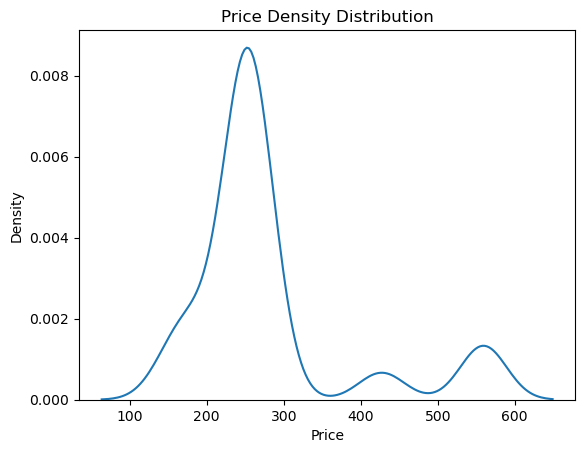

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your list of prices
prices = top_similar_flights_with_price['Total']

# Create the density plot
sns.kdeplot(prices, bw_adjust=0.5)  # Adjust the bandwidth (smoothness) with bw_adjust if necessary

# Adding titles and labels for clarity
plt.title('Price Density Distribution')
plt.xlabel('Price')
plt.ylabel('Density')

# Show the plot
plt.show()


In [117]:
# next steps:

In [ ]:
1- give a buffer space for departure date